frame shape (2160, 3840, 3)
total NF 1393.0
frame shape (2160, 3840, 3)
total NF 2350.0
frame shape (2160, 3840, 3)
total NF 318810.0
frame shape (2160, 3840, 3)
total NF 834806.0
frame shape (2160, 3840, 3)
total NF 969499.0
frame shape (2160, 3840, 3)
total NF 1249969.0
frame shape (2160, 3840, 3)
total NF 1362882.0
frame shape (2160, 3840, 3)
total NF 1310756.0
frame shape (2160, 3840, 3)
total NF 1399566.0
frame shape (2160, 3840, 3)
total NF 1384438.0
frame shape (2160, 3840, 3)
total NF 1418170.0
frame shape (2160, 3840, 3)
total NF 1384683.0
frame shape (2160, 3840, 3)
total NF 1422626.0
frame shape (2160, 3840, 3)
total NF 1400500.0
frame shape (2160, 3840, 3)
total NF 1383439.0
frame shape (2160, 3840, 3)
total NF 1510848.0
frame shape (2160, 3840, 3)
total NF 1485608.0
frame shape (2160, 3840, 3)
total NF 1481133.0
frame shape (2160, 3840, 3)
total NF 1509902.0
frame shape (2160, 3840, 3)
total NF 1481596.0
frame shape (2160, 3840, 3)
total NF 1517645.0
frame shape (2160, 384

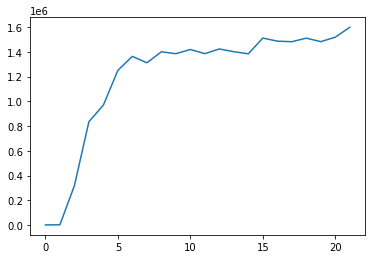

In [34]:
## Video Analysis of Contact Line in Channel ##
## Shane Laibach, with a special thanks to Alejandro Becerra ##

## Video Frame Breakdown ##
import cv2
import numpy as np
from skimage import io, filters #also using SciKit Image Processing Library
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage

# Create a VideoCapture object and read from input file
# If the input is the camera, pass 0 instead of the video file name
cap = cv2.VideoCapture('SDP_2_7_30VF_Trimmed.mp4')


# Check if camera opened successfully
if (cap.isOpened()== False): 
  print("Error opening video stream or file")

## USER INPUTS ###
fps = cap.get(cv2.CAP_PROP_FPS)
frameskip = 15 #frame skip for video processing
edgeslist=[] #leave this be
x0, x1, y0, y1 = [100, 2000,1000, 3000] #window limits on channel closeup
xline0,xline1,yline0,yline1 = [480, 380, 340, 340] #define line
rotation = -2 #angle to rotate image (video) for analysis


# Read until video is completed
count = 0
total_NF = []
while(cap.isOpened()):
    
    # Capture frame-by-frame
    ret, frame = cap.read()
    
    if count == 0:
        datum = frame[:,:,0]
    if ret == True:
        if count % frameskip == 0: ## Every "frameskip" frames
            print('frame shape', frame.shape)
            frame = ndimage.rotate(frame,rotation)
            image= frame[x0: x1, y0: y1,0]
            image = ndimage.gaussian_filter(image,sigma=3.0)
            ## Read and Write Images ##
#             plt.figure()
#             plt.imshow(image)
#             plt.colorbar()
            thresholded = np.where(image<50,1.0,0.0)
            total_NF.append(np.sum(thresholded))
            print('total NF',total_NF[-1])
#             plt.figure()
#             plt.imshow(thresholded)
#             plt.colorbar()
            
            ##Edge Detection##
            #Then, do edge detection to locate the boundaries
            edges1 = filters.prewitt(image)
            edges = ndimage.rotate(edges1,rotation)
            np.save('EdgeProb/edge_probability_'+str(count)+'.npy', edges)
#             plt.figure()
#             plt.title('Raw Edge Detection')
#             io.imshow(edges)
#             io.show()
            edges[:,:] = np.load('EdgeProb/edge_probability_'+str(count)+'.npy')
            edgeslist.append(edges)
            
        # Press Q on keyboard to  exit
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break

    # Break the loop
    else:
        break
    
    count = count + 1
plt.figure()
plt.plot(total_NF)

# When everything done, release the video capture object
cap.release()

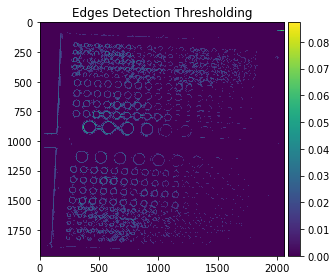

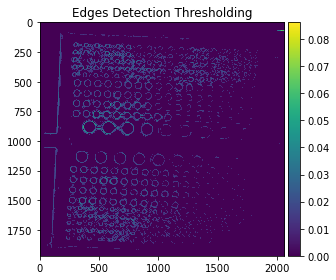

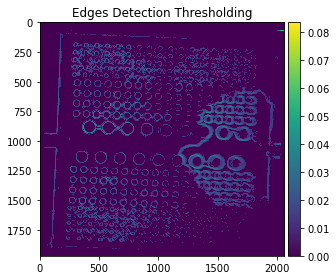

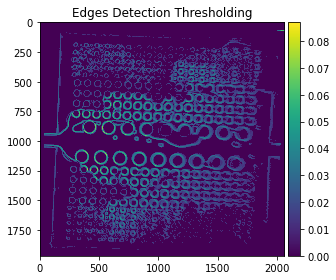

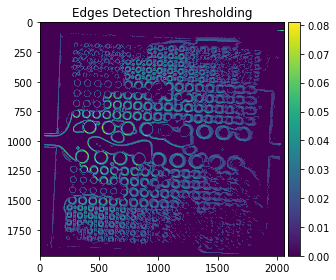

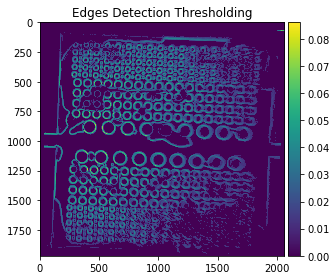

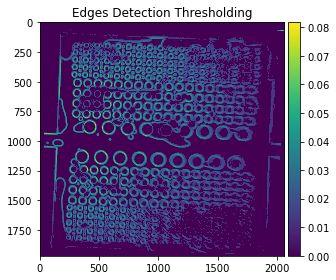

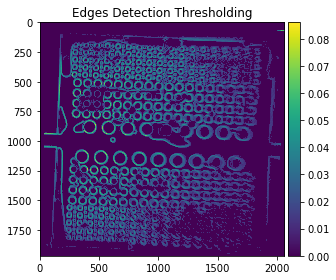

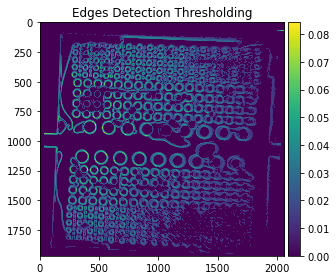

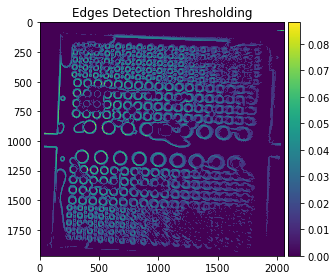

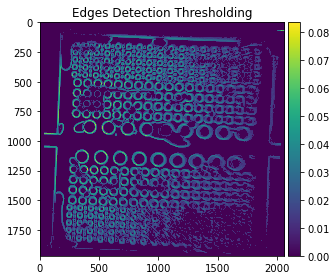

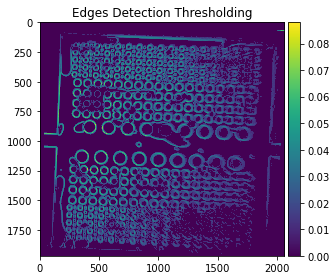

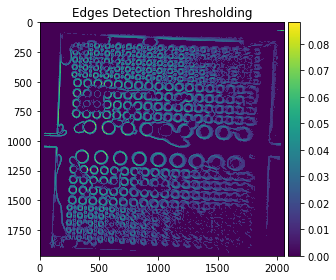

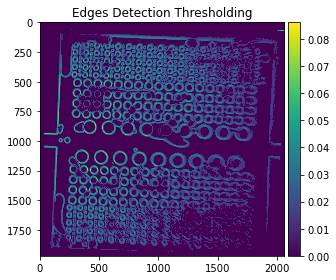

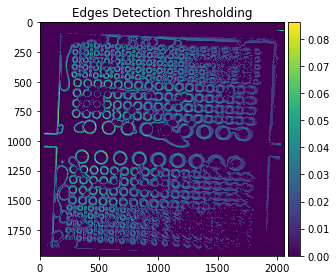

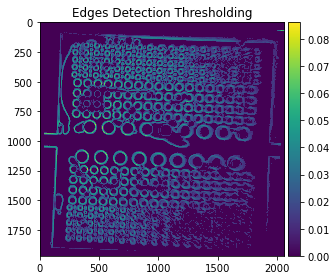

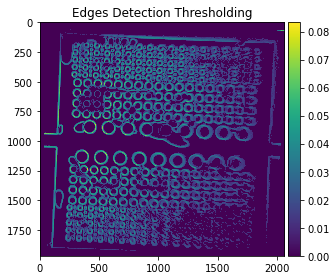

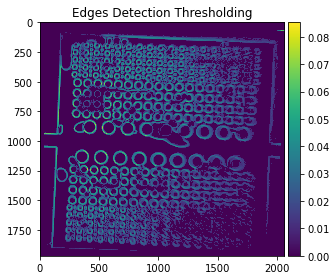

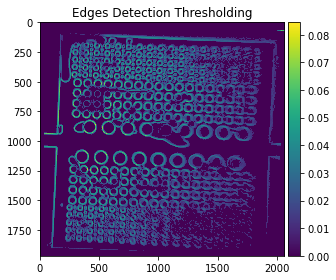

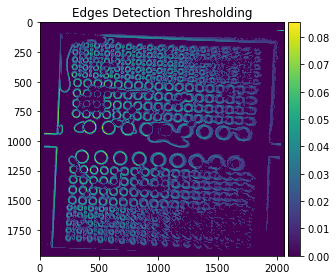

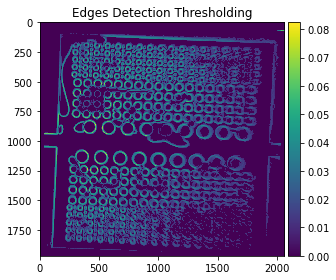

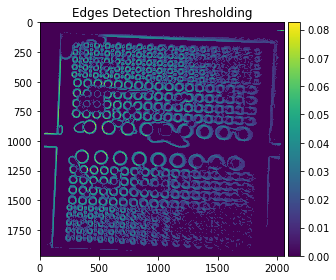

In [37]:
## Convert Edges into binary arrays ##
## USER INPUT ##
threshvar = .01 #threshold factor for edge detection (scale of 0-.6)

length = len(edgeslist)
edgesthreshlist = [] #empty lists for later indexing the edges
edgeslogiclist = []

for i in range(length) :
    edgesthresh = (edgeslist[i] > threshvar) * edgeslist[i] #thresholding the edges array (anything less than threshvar is left out)
    edgesthreshlist.append(edgesthresh)

    edgeslogic = np.array(edgesthresh, dtype = bool) #converting to logical array for comparing
    edgeslogiclist.append(edgeslogic)
    plt.title('Edges Detection Thresholding')
    io.imshow(edgesthresh)
    io.show()


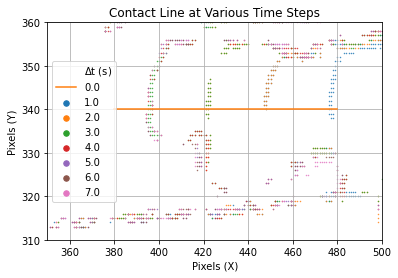

In [3]:
## Comparing Edge arrays to find movement of contact line ##
comparisonlist = []
plotnamelist = []

plt.plot([], [], ' ', label="Extra label on the legend")

for j in range(length-1) :
    contactlinechange = np.where(edgeslogiclist[j] != edgeslogiclist[j+1]) #by finding where the edges are different, can find contact line
    changededge = edgeslist[j][contactlinechange] #the changed edge between frames
    origsize = np.shape(edges)
    sizededge = np.zeros(origsize)
    sizededge[contactlinechange] = changededge #all are same size now so can be overlapped
    comparisonlist.append([(contactlinechange[0][i], contactlinechange[1][i]) for i in range(len(contactlinechange[0]))]) #Plotting all moved and sized edges onto plot
    plt.scatter(contactlinechange[0], contactlinechange[1], s=.2)

# plt.plot([xline0,xline1],[yline0,yline1])
plt.xlim(x0, x1)
plt.ylim(y0, y1)
plt.xlabel('Pixels (X)')
plt.ylabel('Pixels (Y)')
plt.title('Contact Line at Various Time Steps')
plt.grid()
lgnd = plt.legend(['$\Delta$t (s)']+[frameskip*i/fps for i in range(length+1)])
for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._sizes = [30]
plt.savefig('Contact_Line_Time_Steps.png')
plt.show()

In [4]:
## Find Contact Line Velocity ##
# Defining line pre-defined by user
def get_velocity(b):
    m = (yline1-yline0) / (xline1-xline0)
    b = yline0 - m*xline0 + b
    N = int(abs(xline1 - xline0))
    z = np.linspace(xline0,xline1,N)
    w = m*z + b*np.ones(N) #points on the line defined by the user
    midline = list(zip(z,w))
    distance = [np.array([[np.linalg.norm(np.array(midline[i]) - np.array(comparisonlist[k][j])) for j in range(len(comparisonlist[k]))] for i in range(len(midline))]) for k in range(len(comparisonlist))]
    all_mins = [np.min(distance[k]) for k in range(len(distance))]
    all_locations = [list(np.asarray(np.where(distance[k] == np.min(distance[k]))).T[0]) for k in range(len(distance))]
    return([list(comparisonlist[i][all_locations[i][1]]) for i in range(len(all_locations))])

sigmab = np.linspace(-5, 5, 3) #a set of lines that are sampled for their intersections at each time step
UQ = list(zip(*[get_velocity(sigmab[i]) for i in range(len(sigmab))]))
avgUQ = [np.mean(UQ[i], axis=0) for i in range(len(UQ))]
stdUQ = [np.std(UQ[i], axis=0) for i in range(len(UQ))]

print(UQ)
stdfactor = 1.5 #user defined factor for getting rid of junk data points from line intersects

newUQ = []
for i in range(len(UQ)):
    for j in range(len(UQ[i])):
        if UQ[i][j][0] > avgUQ[j][0] + stdfactor*stdUQ[j][0] or UQ[i][j][0] < avgUQ[j][0] - stdfactor*stdUQ[j][0] or UQ[i][j][1] > avgUQ[j][1] + stdfactor*stdUQ[j][1] or UQ[i][j][1] < avgUQ[j][1] - stdfactor*stdUQ[j][1]:
            newUQ.append([UQ[i][k] for k in range(len(UQ[i])) if UQ[i][k] != UQ[i][j]])
    
newavgUQ = [np.mean(newUQ[i], axis=0) for i in range(len(newUQ))]
newstdUQ = [np.std(newUQ[i], axis=0) for i in range(len(newUQ))]

for i in range(len(UQ)):
    print(newUQ[i])
    print(newavgUQ[i])
    print(newstdUQ[i])
    print('\n')
    

[([478, 338], [477, 340], [478, 345]), ([423, 334], [448, 340], [449, 345]), ([396, 335], [395, 340], [396, 345]), ([398, 335], [397, 340], [395, 345]), ([395, 335], [394, 337], [395, 345]), ([395, 335], [394, 339], [395, 344]), ([398, 335], [394, 339], [395, 344])]
[[478, 338], [478, 345]]
[478.  341.5]
[0.  3.5]


[[478, 338], [477, 340]]
[477.5 339. ]
[0.5 1. ]


[[448, 340], [449, 345]]
[448.5 342.5]
[0.5 2.5]


[[423, 334], [448, 340]]
[435.5 337. ]
[12.5  3. ]


[[395, 340], [396, 345]]
[395.5 342.5]
[0.5 2.5]


[[396, 335], [396, 345]]
[396. 340.]
[0. 5.]


[[397, 340], [395, 345]]
[396.  342.5]
[1.  2.5]




In [5]:
deltapixels = [[[np.linalg.norm(np.array(newavgUQ[i]) - np.array(newavgUQ[i+1])) for i in range(len(newavgUQ)-1)]]]

In [6]:
deltapixels


[[[2.5495097567963922,
   29.21044333795706,
   14.115594213493104,
   40.37635446644484,
   2.5495097567963922,
   2.5,
   2.5495097567963922,
   2.23606797749979,
   1.118033988749895,
   1.5811388300841898,
   2.0615528128088303,
   2.0615528128088303,
   2.8284271247461903]]]

In [8]:
## Oil Displacement ##


[array([478. , 341.5]),
 array([477.5, 339. ]),
 array([448.5, 342.5]),
 array([435.5, 337. ]),
 array([395.5, 342.5]),
 array([396., 340.]),
 array([396. , 342.5]),
 array([396.5, 340. ]),
 array([394.5, 341. ]),
 array([395., 340.]),
 array([394.5, 341.5]),
 array([395. , 339.5]),
 array([394.5, 341.5]),
 array([396.5, 339.5])]

# List of Figures

Me: 

Need an experimental schematic figure
    valves, channel, tubes, syringe pumps, camera

Need a science schematic
    nanoparticle wedge film figure

need a plot of % of oil displaced vs. np volume fraction

Egor:

Contact Line vs. Time for different volume fractions
Optional: Plot of % oil displaced vs. non-dimensional flow rate
            Plot of oil displaced vs. shear rate (1/s) volumetric flow rate/volume (just volume of chamber)
